<div style="text-align:center;"><h1>AI vs Human text Classification (99%+ Accuracy)</h1></div>


### DataSet Source:
https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text 

## Flow of whole project
- Imported necessary libraries and loaded the dataset.
- Separated features and labels in the dataset for further processing.
- Tokenized the data, resulting in **303,355 tokens**.
- Saved tokenization for easy reloading, optimizing memory usage, and preventing crashes.
- Padded the first **20%** of the dataset to ensure uniform sequence lengths.
- Trained the model on the initial **20%** with a validation accuracy exceeding **99%**.
- Tested the model on the next **40% of the data**, comprising **194,894 inputs**.
- Achieved an impressive accuracy rate of **99.2%** during testing.

In [102]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tokenized/tokenizer_config.json
/kaggle/input/tokenized/tokenized_sequences.json
/kaggle/input/ai-vs-human-text/AI_Human.csv


## Loading Dataset AI vs Human

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import Callback

In [26]:
# Loading data
data = pd.read_csv('/kaggle/input/ai-vs-human-text/AI_Human.csv')

In [27]:
# Preprocessing data
label = data['generated']
df = data.rename(columns={"generated": "label"})
text = data['text'].str.lower()

In [28]:
del df
del data

In [29]:
del text

In [ ]:
# already tokenzed and save to local machine to counter ram crashing
# Tokenization
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
import json
# Save the tokenizer configuration to a file
tokenizer_config = tokenizer.to_json()
with open('tokenizer_config.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_config, ensure_ascii=False))

# Save the sequences (if needed)
# Assuming 'sequences' is a list of tokenized sequences
with open('tokenized_sequences.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(sequences, ensure_ascii=False))

In [30]:
import json
# Loading data
with open('/kaggle/input/tokenized/tokenized_sequences.json', 'r', encoding='utf-8') as f:
    tokenized_sequences = json.load(f)
with open('/kaggle/input/tokenized/tokenizer_config.json', 'r', encoding='utf-8') as f:
    tokenizer_config = json.load(f)


In [31]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json
tokenizer = tokenizer_from_json(tokenizer_config)
len(tokenized_sequences)

487235

In [32]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

303355

In [33]:
max_sequence_length = max(len(seq) for seq in tokenized_sequences)
max_sequence_length

4714

### Padding only 20%

In [34]:
# Divide the sequences into four variables
num_sequences = len(tokenized_sequences)
label1 = label[:num_sequences//5]

In [35]:
from keras.preprocessing.sequence import pad_sequences
max_sequence_length = max(len(seq) for seq in tokenized_sequences)
padded_sequences1 = pad_sequences(tokenized_sequences[:num_sequences//5], maxlen=max_sequence_length, padding='pre')

In [36]:
label1 = label1.astype('int8')
label1.value_counts()

generated
0    51358
1    46089
Name: count, dtype: int64

In [38]:
del tokenized_sequences

In [39]:
padded_sequences1.shape

(97447, 4714)

### Test,Train,Validation split

In [41]:
# Train-test split
X_train, X_test_temp, y_train, y_test_temp = train_test_split(padded_sequences1, label1, test_size=0.3, random_state=42, stratify=label1)

del padded_sequences1

X_val, X_test, y_val, y_test = train_test_split(X_test_temp, y_test_temp, test_size=0.4, random_state=42, stratify=y_test_temp)
del X_test_temp, y_test_temp


## Model 

In [75]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.initializers import glorot_uniform

model = Sequential([
    Embedding(input_dim=303354, output_dim=100, input_length=4714),
#     Bidirectional(LSTM(123, return_sequences=True, kernel_initializer=glorot_uniform())),
#     Bidirectional(LSTM(53, return_sequences=True, kernel_initializer=glorot_uniform())),
#     Bidirectional(LSTM(53, return_sequences=True, kernel_initializer=glorot_uniform())),
    Bidirectional(LSTM(23, kernel_initializer=glorot_uniform())),
    BatchNormalization(epsilon=1e-3),
    Dropout(0.5),
    Dense(29,activation='relu'),
    Dropout(0.2),
    Dense(13,activation='relu'),
    Dense(7,activation='relu'),
    Dense(1,activation='sigmoid')
])

In [76]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 4714, 100)         30335400  
                                                                 
 bidirectional_5 (Bidirecti  (None, 46)                22816     
 onal)                                                           
                                                                 
 batch_normalization_2 (Bat  (None, 46)                184       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 46)                0         
                                                                 
 dense_8 (Dense)             (None, 29)                1363      
                                                                 
 dropout_4 (Dropout)         (None, 29)               

In [77]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
# Compiling the model for binary classification
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


## Data Generator

In [71]:
def data_generator(features, labels, batch_size=16):
    num_samples = len(features)
    num_batches = num_samples // batch_size
    batch_index = 0

    while True:
        start = batch_index * batch_size
        end = (batch_index + 1) * batch_size

        batch_features = features[start:end]
        batch_labels = labels[start:end]

        yield np.array(batch_features), np.array(batch_labels)

        batch_index += 1
        if batch_index >= num_batches:
            batch_index = 0


In [65]:
X_train.shape

(68212, 4714)

In [66]:
y_train.shape

(68212,)

In [72]:
batch_size = 16
train_generator = data_generator(X_train, y_train, batch_size)
val_generator = data_generator(X_val, y_val, batch_size)

## Training

In [78]:
# Training the model
history = model.fit(
    train_generator, 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=1,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size
)

4263/4263 [==============================] - 1060s 248ms/step - loss: 0.1227 - accuracy: 0.9589 - val_loss: 0.4447 - val_accuracy: 0.8577


In [79]:
# Training the model
history = model.fit(
    train_generator, 
    steps_per_epoch=len(X_train) // batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=len(X_val) // batch_size
)

Epoch 1/5
4263/4263 [==============================] - 1016s 238ms/step - loss: 0.0681 - accuracy: 0.9803 - val_loss: 0.0411 - val_accuracy: 0.9916
Epoch 2/5
4263/4263 [==============================] - 1020s 239ms/step - loss: 0.0535 - accuracy: 0.9846 - val_loss: 0.0694 - val_accuracy: 0.9779
Epoch 3/5
4263/4263 [==============================] - 1020s 239ms/step - loss: 0.0250 - accuracy: 0.9935 - val_loss: 0.0446 - val_accuracy: 0.9850
Epoch 4/5
4263/4263 [==============================] - 1013s 238ms/step - loss: 0.0167 - accuracy: 0.9956 - val_loss: 0.0300 - val_accuracy: 0.9940
Epoch 5/5
4263/4263 [==============================] - 1012s 237ms/step - loss: 0.0161 - accuracy: 0.9955 - val_loss: 0.0287 - val_accuracy: 0.9942


## Test


Testing on the test data generated in test train validation split

In [80]:
# Evaluate the model on the test set
evaluation_result = model.evaluate(X_test, y_test)

# The evaluation_result contains the loss value and accuracy
test_loss, test_accuracy = evaluation_result
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

366/366 [==============================] - 56s 148ms/step - loss: 0.0414 - accuracy: 0.9929
Test Loss: 0.0414
Test Accuracy: 99.29%


In [84]:
# Save the entire model to a TensorFlow SavedModel format
tf.saved_model.save(model, "/kaggle/working/model1_9929")

## Visualization of Test vs Train Accuracy

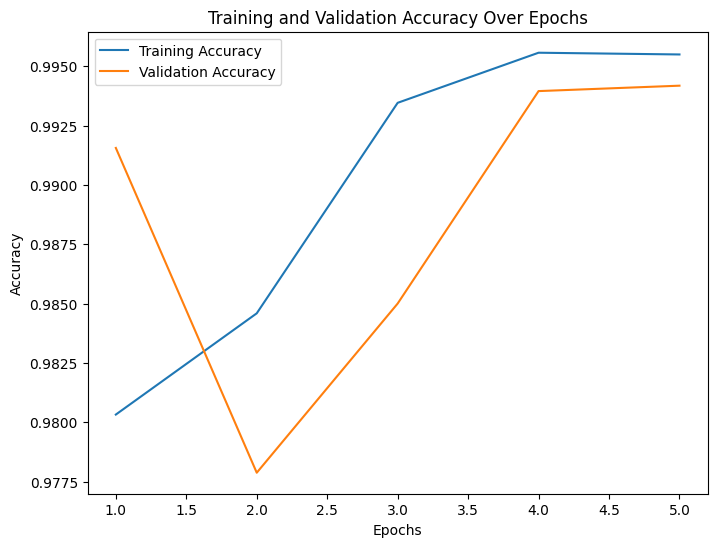

In [101]:
import matplotlib.pyplot as plt
# Plotting the training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = np.arange(1, 6)  # Assuming you trained for 5 epochs

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Testing on next 20% data

#### Reloading tokenizer saved during code for avoiding RAM crash and preprocessing again

In [87]:
import json
# Loading data
with open('/kaggle/input/tokenized/tokenized_sequences.json', 'r', encoding='utf-8') as f:
    tokenized_sequences = json.load(f)
with open('/kaggle/input/tokenized/tokenizer_config.json', 'r', encoding='utf-8') as f:
    tokenizer_config = json.load(f)

In [88]:

from keras.preprocessing.sequence import pad_sequences
max_sequence_length = max(len(seq) for seq in tokenized_sequences)
padded_sequences2 = pad_sequences(tokenized_sequences[num_sequences//5:2*num_sequences//5], maxlen=max_sequence_length, padding='pre')

In [89]:
label2 = label[num_sequences//5:2*num_sequences//5]

In [90]:
label2 = label2.astype('int8')
label2.value_counts()


generated
0    66304
1    31143
Name: count, dtype: int64

#### Accuracy 99.39%

In [91]:
# Evaluate the model on the test set
evaluation_result = model.evaluate(padded_sequences2, label2)

# The evaluation_result contains the loss value and accuracy
test_loss, test_accuracy = evaluation_result
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

3046/3046 [==============================] - 449s 147ms/step - loss: 0.0270 - accuracy: 0.9939
Test Loss: 0.0270
Test Accuracy: 99.39%


In [92]:
del padded_sequences2

## Testing on rest 20% more data

#### Doing again same things for next 20% data(0.4 -0.6) to check model performance

In [95]:
padded_sequences3 = pad_sequences(tokenized_sequences[2*num_sequences//5:3*num_sequences//5], maxlen=max_sequence_length, padding='pre')
label3 = label[2*num_sequences//5:3*num_sequences//5].astype('int8')
label3.info()

<class 'pandas.core.series.Series'>
RangeIndex: 97447 entries, 194894 to 292340
Series name: generated
Non-Null Count  Dtype
--------------  -----
97447 non-null  int8 
dtypes: int8(1)
memory usage: 95.3 KB


In [99]:
label3.value_counts()

generated
0    61828
1    35619
Name: count, dtype: int64

#### Accuracy 99.11%

In [100]:
# Evaluate the model on the test set
evaluation_result = model.evaluate(padded_sequences3, label3)

# The evaluation_result contains the loss value and accuracy
test_loss, test_accuracy = evaluation_result
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

3046/3046 [==============================] - 450s 148ms/step - loss: 0.0397 - accuracy: 0.9911
Test Loss: 0.0397
Test Accuracy: 99.11%


<div style="text-align:center;"><h1>Your Feedback Would be Appreciated</h1></div>
